In [ ]:
# load some packages
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import pandas as pd

# load the catalogue
catalogue = np.load('catalogue_1000sqd.npy')
type(catalogue)
print("ndarray.dtype:", catalogue.dtype)

nside = 64 # HEALPix nside parameter

#Load the Power Spectrum and generate a convergence map
cl_kappa = np.loadtxt('cl_kappa.txt')
cl_kappa = np.concatenate((np.zeros(2), cl_kappa)) # add zeros for monopole and dipole
kappamap = hp.synfast(cl_kappa, nside) # generate a convergence map
kappamap.shape

ndarray.dtype: [('template_coeffs_abs', '<f4', (5,)), ('mag g', '<f4'), ('int_mag i', '<f4'), ('int_mag g', '<f4'), ('int_r50', '<f4'), ('bkg_noise_amp g', '<f8'), ('id', '<i8'), ('template_coeffs', '<f4', (5,)), ('abs_mag z', '<f4'), ('r50', '<f4'), ('abs_mag_lumfun', '<f4'), ('mag r', '<f4'), ('gamma2', '<f4'), ('sersic_n', '<f4'), ('e1', '<f4'), ('excess_b_v', '<f4'), ('e_abs', '<f8'), ('mag y', '<f4'), ('abs_mag r', '<f4'), ('ra', '<f4'), ('dec', '<f4'), ('mag i', '<f4'), ('int_mag r', '<f4'), ('int_mag y', '<f4'), ('bkg_noise_amp y', '<f8'), ('int_mag z', '<f4'), ('kappa', '<f4'), ('abs_mag g', '<f4'), ('abs_mag y', '<f4'), ('z', '<f4'), ('int_e2', '<f4'), ('int_e1', '<f4'), ('abs_mag i', '<f4'), ('mag z', '<f4'), ('bkg_noise_amp z', '<f8'), ('e2', '<f4'), ('bkg_noise_amp r', '<f8'), ('bkg_noise_amp i', '<f8'), ('gamma1', '<f4'), ('galaxy_type', '<u2')]


(49152,)

In [4]:
lon_center = np.mean(catalogue['ra'])
lat_center = np.mean(catalogue['dec'])
lon_range = 1 # plotting range in degrees
lat_range = 1

pixscale = 0.263
sizes_in_arcsec = catalogue['r50'] * pixscale   # arcsec

In [ ]:
# Convert galaxy coordinates to HEALPix pixel indices
galaxy_pix = hp.ang2pix(nside, np.radians(catalogue['ra']), np.radians(catalogue['dec']))
galaxy_pix_unique, galaxy_pix_counts = np.unique(galaxy_pix, return_counts=True)

n_pixels = hp.nside2npix(nside)
print("Total number of galaxies:", len(catalogue))
print("Total number of pixels:", n_pixels)
print("Number of unique pixels with galaxies:", len(galaxy_pix_unique))
print("Max number of galaxies in a pixel:", np.max(galaxy_pix_counts))


(117628,)
Total number of galaxies: 117628
Total number of pixels: 49152
Number of unique pixels with galaxies: 160
Max number of galaxies in a pixel: 1930


In [6]:
# Add a float32 field named 'pixel'
new_dtype = catalogue.dtype.descr + [('pixel', 'int32')]
catalogue2 = np.empty(catalogue.shape, dtype=new_dtype)

for name in catalogue.dtype.names:
    catalogue2[name] = catalogue[name]

catalogue2['pixel'] = galaxy_pix  # Assign the pixel to each galaxy


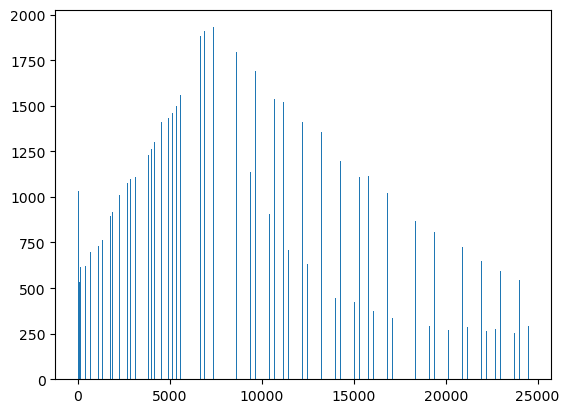

In [7]:
plt.hist(catalogue2['pixel'], bins= 1000)
plt.show()

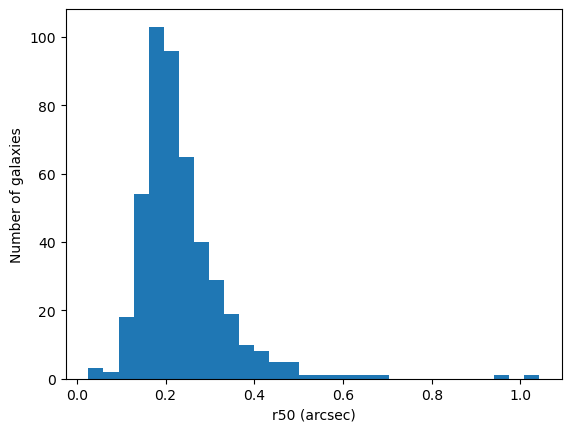

In [8]:
plt.hist(sizes_in_arcsec[catalogue2['pixel'] == 0], bins=30)
plt.xlabel('r50 (arcsec)')
plt.ylabel('Number of galaxies')
plt.show()

In [ ]:
for i in galaxy_pix_unique[:10]:  # Just show the first 10 unique pixels for brevity
    print(f"Pixel {i} has {galaxy_pix_counts[galaxy_pix_unique == i][0]} galaxies")
    plt.hist(sizes_in_arcsec[catalogue2['pixel'] == i], bins=30)
    plt.xlabel('r50 (arcsec)')
    plt.ylabel('Number of galaxies')
    plt.title(f'Size distribution in Pixel {i}')
    plt.show()

## Implementation of the Maximum Mean Distance (MMD) between two distributions given only their samples.


### Note: Eventuell muss man noch die sample data normalisieren!

In [10]:
import sklearn
from sklearn.metrics.pairwise import pairwise_distances, rbf_kernel,  polynomial_kernel, linear_kernel, sigmoid_kernel, laplacian_kernel, chi2_kernel

print("pixel 0:", "\nMIN:", sizes_in_arcsec[catalogue2['pixel'] == 0].min(),
      ", MAX():", sizes_in_arcsec[catalogue2['pixel'] == 0].max(),
      ", MEAN():", sizes_in_arcsec[catalogue2['pixel'] == 0].mean())
print("Whole Disitribution:", "\nMIN:", sizes_in_arcsec.min(),
      ", MAX():", sizes_in_arcsec.max(),
      ", MEAN():", sizes_in_arcsec.mean())

print("\nComparing pixel 0 with the entire catalogue, we see that their Max/Min values are quite different.",
      "\nThis could lead to numerical issues when calculating the MMD if we use a fixed bandwidth for the RBF kernel.",
      "\nThink of normlaizing the data before computing the MMD.")

pixel 0: 
MIN: 0.025864894 , MAX(): 1.0427532 , MEAN(): 0.2350141
Whole Disitribution: 
MIN: 0.012933485 , MAX(): 6.3672323 , MEAN(): 0.24530084

Comparing pixel 0 with the entire catalogue, we see that their Max/Min values are quite different. 
This could lead to numerical issues when calculating the MMD if we use a fixed bandwidth for the RBF kernel. 
Think of normlaizing the data before computing the MMD.


In [11]:
def MMD2_biased(X, Y, kernel=rbf_kernel, **kwargs):
    """Compute the biased estimate of Maximum Mean Discrepancy (MMD) between two samples: X and Y.
    
    Parameters:
    - X: np.ndarray of shape (n_samples_X, n_features)
    - Y: np.ndarray of shape (n_samples_Y, n_features)
    - kernel: function, the kernel function to use (default: RBF kernel)
    - **kwargs: additional arguments for the kernel function
    
    Returns:
    - mmd2: float, the biased MMD^2 estimate
    """
    K_XX = kernel(X, X, **kwargs)
    K_YY = kernel(Y, Y, **kwargs)
    K_XY = kernel(X, Y, **kwargs)
    
    mmd2 = K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()
    return mmd2

Calculating K_YY is very expensive and takes a lot of time, since Y has 117,000 samples. Instead of caluclating K_YY exactly, we will try two options:
1. Linear time unbiased MMD
2. Monte Carlo MMD.

In [12]:
X= sizes_in_arcsec[catalogue2['pixel'] == 0].reshape(-1,1)
Y= sizes_in_arcsec.reshape(-1,1)
# mmd2_value = MMD2_biased(X, Y, kernel=rbf_kernel, gamma=1.0)
# print(f"MMD^2 between pixel 0 and the entire catalogue: {mmd2_value}")


#### Monte Carlo MMD:
We only use a subsample of Y to estimate K_YY.mean().
This first approach is only usable for small Y sizes. I.e. 1-3k, not 10k.

In [13]:
def rbf_kernel_factory(sigma):
    gamma = 1.0 / (2.0 * sigma**2)
    def k(X, Y):
        # X: (m,d), Y: (n,d)
        X2 = np.sum(X**2, axis=1, keepdims=True)      # (m,1)
        Y2 = np.sum(Y**2, axis=1, keepdims=True).T    # (1,n)
        D2 = X2 + Y2 - 2 * X @ Y.T
        return np.exp(-gamma * D2)
    return k

def median_sigma(X, Y, max_samples=5000, eps=1e-12):
    Z = np.vstack([X, Y])
    if Z.shape[0] > max_samples:
        idx = np.random.choice(Z.shape[0], size=max_samples, replace=False)
        Z = Z[idx]
    D2 = np.square(Z[:,None,:] - Z[None,:,:]).sum(axis=2)
    tri = D2[np.triu_indices_from(D2, k=1)]
    med = np.median(tri[tri > 0])
    return float(np.sqrt(max(med, eps)))

def gram_matrix(X,Y, kernel, ):
    # kernel: callable (X,Y) -> (len(X), len(Y)) Gram Matrix
    return kernel(X,Y)

def mmd2_biased_from_kernel(X,Y, kernel):
    Kxx = gram_matrix(X,X, kernel )
    Kyy = gram_matrix(Y,Y, kernel )
    Kxy = gram_matrix(X,Y, kernel)
    return Kxx.mean() + Kyy.mean() - 2*Kxy.mean()

def random_sampling(Y, n_sample, replace=False):
    Y_sample = np.random.choice(Y.reshape(-1,), size=n_sample, replace=replace)  #with or without replacement?
    return Y_sample

For larger sample sizes of Y, we want to compute the mean of K_YY without storing the full Gram Matrix.

We want to estimate MMD^2 = E[k(X,X')] + E[k((Y,Y'))] - 2E[k(X,Y)].
The first term is cheap and can be computed exactly. The second term is computed using monte carlo estimation with many random distinct pairs from Y. The third term computes the exact cross-term mean without building the full m x n Gram Matrix by processing Y in blocks.

In [14]:
#Compute E[k(X,X)] exactly without diagonal terms (i.e. unbiased)
def unbiased_Exx(X,sigma):
    inv2s2= 1.0 /(2.0*sigma**2)
    D2 = np.square(X[:, None,:] - X[None, :, :]).sum(axis=2)
    np.fill_diagonal(D2,np.nan)
    return np.nanmean(np.exp(-inv2s2*D2))

#Compute E[k(Y,Y)] by sampling many distinct pairs from Y. (Monte Carlo)
def MC_Eyy(Y, sigma, n_pairs=200_000, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    n = Y.shape[0]
    i = rng.integers(0, n, size=n_pairs)
    j = rng.integers(0, n-1, size=n_pairs)
    j = j + (j >= i)  # ensure j != i
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    D2 = np.square(Y[i] - Y[j]).sum(axis=1)
    return np.mean(np.exp(-inv2s2 * D2))

#Compute E[k(X,Y)] exactly without storing full Gram matrix (uses rbf kernel)
def mean_rbf_xy(X, Y, sigma, block=500_000):
    inv2s2 = 1.0 / (2.0 * sigma * sigma)
    m = X.shape[0]; n = Y.shape[0]
    total = 0.0; count = 0
    for s in range(0, n, block):
        Yb = Y[s:s+block]
        X2 = np.sum(X**2, axis=1, keepdims=True)      # (m,1)
        Y2 = np.sum(Yb**2, axis=1, keepdims=True).T   # (1,|b|)
        D2 = X2 + Y2 - 2 * X @ Yb.T
        K = np.exp(-inv2s2 * D2)
        total += K.sum(); count += K.size
    return total / count

#Compute the MMD using the above three functions
def mmd2_biased_fast(X, Y, sigma, n_pairs_yy=200_000):
    """
    Suitable for small X and large Y. If X becomes large too using a different galaxy catalogue,
    consider changing this function to compute E_XX also using MC.
    """
    exx = unbiased_Exx(X, sigma)                 # tiny (m~100)
    exy = mean_rbf_xy(X, Y, sigma)               # exact mean, blockwise
    eyy = MC_Eyy(Y, sigma, n_pairs_yy)           # Monte-Carlo
    return exx + eyy - 2.0 * exy


#Helperfunction to find a good value of sigma for the rbf kernel using median heuristic approach
def sigma_median(X, Y, max_y=5000, rng=None, eps=1e-12):
    rng = np.random.default_rng() if rng is None else rng
    Yc = Y if Y.shape[0] <= max_y else rng.choice(Y.ravel(), size=max_y, replace=False).reshape(-1,1)
    Z = np.vstack([X, Yc])
    D2 = (Z[:,None,:] - Z[None,:,:])**2
    tri = D2[np.triu_indices_from(D2[:,:,0], k=1)]
    med = np.median(tri[tri > 0])
    return float(np.sqrt(max(med, eps)))


In [15]:
#CLAUDE
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel

def mmd_rbf(X, Y, gamma=None, chunk_size=5000,n_pairs_yy=200_000, rng=None):
    """
    Compute Maximum Mean Discrepancy with RBF kernel for imbalanced samples.
    
    Parameters:
    -----------
    X : array-like, shape (m, d)
        Samples from first distribution (smaller sample)
    Y : array-like, shape (n, d)
        Samples from second distribution (larger sample)
    gamma : float, optional
        RBF kernel bandwidth parameter. If None, uses 1.0 / n_features
    chunk_size : int
        Process Y in chunks to manage memory for large samples
    
    Returns:
    --------
    mmd : float
        MMD estimate between the two distributions
    """
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    m, n = len(X), len(Y)
    
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    
    # Term 1: E[k(X, X')] - can compute directly since X is small
    XX = rbf_kernel(X, X, gamma=gamma)
    # Exclude diagonal (comparing sample with itself)
    term1 = (XX.sum() - np.trace(XX)) / (m * (m - 1))
    
    # # Term 2: E[k(Y, Y')] - use chunking for memory efficiency
    # # For very large Y, we can subsample or use an unbiased estimator
    # if n > 10000:
    #     # Unbiased U-statistic estimator using random pairs
    #     n_pairs = min(10000, n * (n - 1) // 2)
    #     idx1 = np.random.randint(0, n, n_pairs)
    #     idx2 = np.random.randint(0, n, n_pairs)
    #     # Ensure i != j
    #     mask = idx1 != idx2
    #     idx1, idx2 = idx1[mask], idx2[mask]
        
    #     YY_samples = rbf_kernel(Y[idx1], Y[idx2], gamma=gamma)
    #     term2 = np.mean(np.diag(YY_samples))
    # else:
    #     YY = rbf_kernel(Y, Y, gamma=gamma)
    #     term2 = (YY.sum() - np.trace(YY)) / (n * (n - 1))
    


    # --- Term 2: E[k(Y,Y')] via Monte-Carlo on DISTINCT pairs ---
    if rng is None:
        rng = np.random.default_rng(0)  # set a fixed seed to match other code when unspecified

    if n > 10000:
        k = int(min(n_pairs_yy, n * (n - 1)))  # number of ordered distinct pairs to sample
        i = rng.integers(0, n, size=k)
        j = rng.integers(0, n - 1, size=k)
        j = j + (j >= i)  # ensure j != i (uniform over ordered distinct pairs)

        # Compute RBF for corresponding pairs WITHOUT building a big Gram matrix
        diff = Y[i] - Y[j]                 # (k,d)
        d2 = np.sum(diff * diff, axis=1)   # (k,)
        term2 = np.mean(np.exp(-gamma * d2))
    else:
        Kyy = rbf_kernel(Y, Y, gamma=gamma)
        term2 = (Kyy.sum() - np.trace(Kyy)) / (n * (n - 1))

    # Term 3: -2 * E[k(X, Y)] - compute in chunks
    term3 = 0.0
    n_chunks = (n + chunk_size - 1) // chunk_size
    
    for i in range(n_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, n)
        Y_chunk = Y[start_idx:end_idx]
        
        XY_chunk = rbf_kernel(X, Y_chunk, gamma=gamma)
        term3 += XY_chunk.sum()
    
    term3 = -2.0 * term3 / (m * n)
    
    mmd = term1 + term2 + term3
    return mmd


def mmd_linear(X, Y, subsample_Y=10000):
    """
    Compute MMD with linear kernel (more efficient for large samples).
    
    For linear kernel: MMD² = ||mean(X) - mean(Y)||²
    This is much more efficient and doesn't require pairwise computations.
    """
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    # For very large Y, optionally subsample
    if subsample_Y and len(Y) > subsample_Y:
        np.random.seed(42)
        Y = Y[np.random.choice(len(Y), subsample_Y, replace=False)]
    
    mean_X = np.mean(X, axis=0)
    mean_Y = np.mean(Y, axis=0)
    
    mmd = np.linalg.norm(mean_X - mean_Y)
    return mmd


def mmd_polynomial(X, Y, degree=3, gamma=None, coef0=1, chunk_size=5000):
    """
    Compute MMD with polynomial kernel.
    """
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    m, n = len(X), len(Y)
    
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    
    # Term 1: E[k(X, X')]
    XX = polynomial_kernel(X, X, degree=degree, gamma=gamma, coef0=coef0)
    term1 = (XX.sum() - np.trace(XX)) / (m * (m - 1))
    
    # Term 2: E[k(Y, Y')] - subsample for efficiency
    if n > 5000:
        np.random.seed(42)
        Y_sub = Y[np.random.choice(n, 5000, replace=False)]
        YY = polynomial_kernel(Y_sub, Y_sub, degree=degree, gamma=gamma, coef0=coef0)
        term2 = (YY.sum() - np.trace(YY)) / (5000 * 4999)
    else:
        YY = polynomial_kernel(Y, Y, degree=degree, gamma=gamma, coef0=coef0)
        term2 = (YY.sum() - np.trace(YY)) / (n * (n - 1))
    
    # Term 3: -2 * E[k(X, Y)]
    term3 = 0.0
    n_chunks = (n + chunk_size - 1) // chunk_size
    
    for i in range(n_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, n)
        Y_chunk = Y[start_idx:end_idx]
        
        XY_chunk = polynomial_kernel(X, Y_chunk, degree=degree, gamma=gamma, coef0=coef0)
        term3 += XY_chunk.sum()
    
    term3 = -2.0 * term3 / (m * n)
    
    mmd = term1 + term2 + term3
    return mmd



In [16]:
sigma = sigma_median(X, Y)
# mmd2_biased_fast(X, Y,sigma=sigma)
gamma = 1.0/ (2.0 * sigma**2)  
mmd_rbf_value = mmd_rbf(X, Y, gamma,)
mmd_linear_value = mmd_linear(X,Y)
mmd_pol_value = mmd_polynomial(X,Y, degree=4)
mmd_rdbf_gpt = mmd2_biased_fast(X,Y, sigma)
print(mmd_rbf_value, mmd_linear_value, mmd_pol_value, mmd_rdbf_gpt)



0.0012296438 0.007440105 -0.01000905 0.0016868114


In [17]:
MMDs = []
pixels = []

# for pixel in range(int(n_pixels)):  #Iteration über alle pixel
#     if sum(catalogue2['pixel']==pixel) < 130:    # Wie viele Galaxien braucht es in einem Pixel, um aussagekräftige Distribution zu haben?
#         continue    

#     #Size distribution of the galaxies in this pixel:
#     X = sizes_in_arcsec[catalogue2['pixel'] == pixel].reshape(-1,1) 
#     #Y ist immer die Grössen aller Galaxien im Katalog
#     sigma = sigma_median(X,Y)                       # Darf sigma individuell bestimmt werden oder muss es für alle vergleiche gleich sein?
#     pixels.append(pixel)
#     MMD2 = mmd2_biased_fast(X,Y, sigma)
#     MMDs.append(MMD2)


In [18]:
def get_MMDs(size_distr, galaxy_pixels, n_gal=100, nside=64):
    """
    Input:
    size_distr: Array with the sizes of all galaxies (preferably converted intop arcsec). 
                -> catalogue['r50']*pixscale
    galaxy_pix: Array with the number of the pixel at which each galaxy is located.
    n_gal:  Threshold number for which the MMD is computed for a pixel. 
            If there are not enough galaxies in the pixel, the MMD will not be computed.

    Output:
    MMDs: np.array of the MMDs between the galaxy size distribution in a pixel and the whole distr
    pixels: np.array of the pixel numbers for which the MMD was computed. Can later be used to get 
            the corresponding kappa value for these pixels.
    """
    Y= size_distr.reshape(-1,1) # Sizes of all galaxies in the right format to work with sklearn

    MMDs =[]
    pixels = []
    n_pix= hp.nside2npix(nside) # Number of pixels

    for pixel in range(n_pix):
        if sum(galaxy_pixels == pixel) < n_gal:
            continue

        X = size_distr[galaxy_pixels==pixel].reshape(-1,1)   # Size of all galaxies in the pixel nr. {pixel}
        sigma = sigma_median(X,Y)      #Q: Can sigma vary or should it be a global variable????
        pixels.append(pixel)   # List of the pixels for which MMD was computed, later used to get the right kappa values
        MMD2 = mmd2_biased_fast(X,Y, sigma=sigma)
        MMDs.append(MMD2)
    MMDs = np.array(MMDs)
    pixels = np.array(pixels)
    return np.sqrt(MMDs), pixels



In [19]:

# print(catalogue2['pixel'])
# print(kappamap[catalogue2['pixel']])  # kappa experienced by each galaxy

intrinsic_sizes = sizes_in_arcsec
observed_sizes = intrinsic_sizes*(1+ kappamap[catalogue2['pixel']])

MMDs_unlensed, pixels_unlensed = get_MMDs(intrinsic_sizes, catalogue2['pixel'])
MMDs_lensed, pixels_lensed = get_MMDs(observed_sizes, catalogue2['pixel'])

/var/folders/yv/7v74fslx3c75zq5f_4bcwblm0000gn/T/ipykernel_7545/3606132724.py:32: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(MMDs), pixels


In [25]:
MMDs_unlensed.shape

(144,)

Text(0.5, 0, '$\\kappa$')

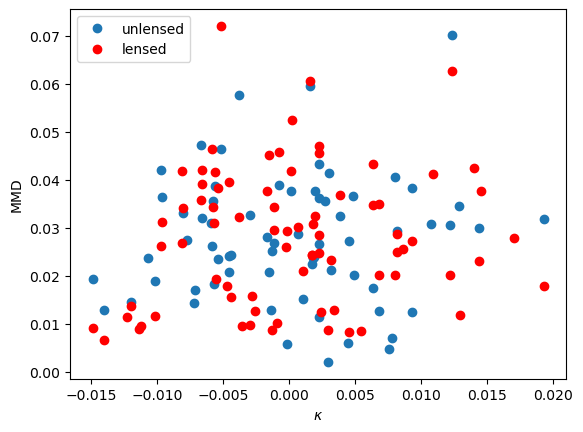

In [20]:
plt.figure()
plt.plot(kappamap[pixels_unlensed], MMDs_unlensed,  'o', label='unlensed')
plt.plot(kappamap[pixels_lensed], MMDs_lensed,  'o', color='r', label='lensed')
plt.legend()
plt.ylabel('MMD')
plt.xlabel(r'$\kappa$')

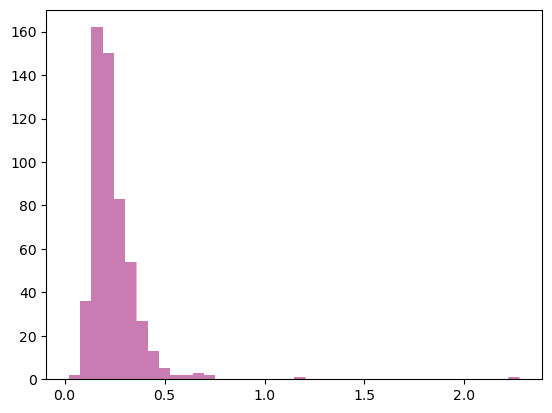

In [21]:
plt.figure()
plt.hist(intrinsic_sizes[catalogue2['pixel']==23999], bins=40, alpha=0.3, color='b')
plt.hist(observed_sizes[catalogue2['pixel']==23999], bins=40, alpha=0.3, color='r')
plt.show()

In [22]:
print(galaxy_pix_unique[156])
kappamap_with_galaxies = kappamap[galaxy_pix_unique]
np.max(kappamap_with_galaxies)


23999


np.float64(0.019271485919069804)

In [23]:
kappamap[23999]

np.float64(0.0017571986072328892)

Current Problem:

We have a function that gives us the MMD for a given size distribution, and location of the galaxies. When we plot the MMDs as function of kappa for lensed and unlensed galaxies, there is no detectable difference.
Is the MMD computation bad?
Is the observed size computation wrong?

Other possible reasons:

We do not have enough galaxies in the catalogue. The kappamap has too low values, in particular the greatest kappa value in a pixel that actually contains a galaxy is 0.01. Compare this to the plot in Noahs report: The shift of the distribution is tiny, even though kappa=0.05 and the pixel contains many more galaxies.